# EnBw DataBiz Challenge

In [2]:
import datetime
from utils.datetime_utils import day_of_year_to_date
from utils.io import read_enbw_dataset
import seaborn as sns
import pandas as pd
import numpy as np
from visualize import visualize_household

filepath = 'data/hackathon_EnBW_smart_meter_data_30_hh.csv'
data = read_enbw_dataset(filepath)

data.head()

households = data.groupby('id')
household_id = 3
# Get a random household
group = households.get_group(household_id)
group.set_index(group.timestampLocal, inplace=True)


## Analyze typical day of household

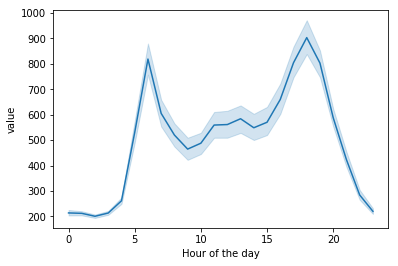

In [3]:

resample = group.resample('1H').mean()
resample['hour_idx'] = resample.index.hour
resample.set_index('hour_idx', inplace=True)
resample.index.name = 'hour_idx'
resample['Hour of the day'] = resample.index 
sns.lineplot(x='Hour of the day', y='value', data=resample)


Um Anomalien zu entdecken, die auf unerwartet niedrigen Stromverbrauch hinweisen, zu finden, haben wir ersteinmal
einige Annahmen getroffen. 

Annahme 1: Nachts am frühen Morgen wird konsistent weniger Strom verbraucht: Benutze "Schlafverbrauch" 
als Referenzsignal für Anomalie.

In [4]:

grouped_by_hour = group.groupby(lambda x: pd.to_timedelta(x.hour, unit='H'))
average_day = grouped_by_hour.value.agg(['mean', 'min', 'max', 'std'])
assumed_inactivity = average_day.sort_values(by='mean').iloc[0:4, :].mean()
assumed_inactivity_std = assumed_inactivity['std']
overall_std = group.value.std()
assumed_inactivity


mean     209.917797
min       54.777500
max     1618.440000
std      112.795392
dtype: float64

## Seasonal Trends
Annahme 2: Der Grundverbrauch verändert sich mittelfristig über das Jahr, bedingt durch Feiertage, 
Schulferien und Klima: der Grundverbrauch. 

Extrahiere saisonale Baseline um unerwartetes Verhalten besser einzuschätzen.


In [5]:
inactivity_anomaly_vectors = []
is_nocturnal_activity_vectors = []

# for day, day_group in grouped_by_day:
day_manual = 0
# day = 229

seasonal_mean = group.resample('1W').mean()
grouped_by_day = group.groupby(lambda x: x.dayofyear)

# Parameters :)
alpha = 0.005
beta = 1 / 2
m = np.reshape([1, 2], (2, 1))

for day, day_group in grouped_by_day:
    try:
        if day_manual > 0:
            day_group = grouped_by_day.get_group(day_manual)
        day_statistics = day_group.resample('1H').value.agg(['mean', 'min', 'max', 'std'])
        day_statistics['offset'] = pd.to_timedelta(day_statistics.index.hour, unit='H')

        date = day_of_year_to_date(day, 2014)
        seasonal_mean['sort_val'] = abs((seasonal_mean.index - date).days)
        unexpected_signal_threshold = seasonal_mean.sort_values('sort_val').iloc[0]['value'] + beta * assumed_inactivity_std

        merged_statistics = day_statistics.merge(average_day, how='left', left_on=day_statistics.offset,
                                                 right_on=average_day.index)

        expectations_to_inactivity = (
                    (average_day['mean'] - assumed_inactivity['mean']) / assumed_inactivity['std']).values
        is_unexpected = average_day['mean'] > unexpected_signal_threshold

        deviation_from_inactivity = (
                (merged_statistics['mean_x'] - assumed_inactivity['mean']) / assumed_inactivity['std']).values
        # comparison_to_night_activity.index.name = 'index'

        deviation_from_expectation = ((merged_statistics['mean_x'] - merged_statistics['mean_y']) / merged_statistics[
            'mean_y']).values

        is_inactivity = deviation_from_inactivity < alpha * overall_std
        is_inactivity_indices, = np.where(deviation_from_inactivity)

        inactivity_anomaly_vector = np.sum(np.vstack((is_unexpected, is_inactivity)).astype(np.int32) * m, axis=0)
        inactivity_anomaly_vectors.append(inactivity_anomaly_vector)

        # 2. anomaly: nocturnal activity
        # nocturnal_activity_vector = np.logical_and(deviation_from_expectation > gamma, night_hours).astype(np.int)
        # is_nocturnal_activity_vectors.append(nocturnal_activity_vector)
        if day_manual > 0:
            break
    except ValueError:
        continue
        

/home/simone/.local/share/virtualenvs/enbw-challenge-0BWRMCLz/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in less

/home/simone/.local/share/virtualenvs/enbw-challenge-0BWRMCLz/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in less



# Ergebnisse

/home/simone/projects/enbw-challenge/enbw-challenge/visualize.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/simone/.local/share/virtualenvs/enbw-challenge-0BWRMCLz/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



            timestampLocal  id    value  sun  holiday      time        date
67683  2014-01-01 00:15:00   3   453.52    0        1  00:15:00  2014-01-01
67684  2014-01-01 00:30:00   3   500.44    0        1  00:30:00  2014-01-01
67685  2014-01-01 00:45:00   3   621.51    0        1  00:45:00  2014-01-01
67686  2014-01-01 01:00:00   3   699.91    0        1  01:00:00  2014-01-01
67687  2014-01-01 01:15:00   3   467.25    0        1  01:15:00  2014-01-01
67688  2014-01-01 01:30:00   3   437.98    0        1  01:30:00  2014-01-01
67689  2014-01-01 01:45:00   3   498.41    0        1  01:45:00  2014-01-01
67690  2014-01-01 02:00:00   3   434.74    0        1  02:00:00  2014-01-01
67691  2014-01-01 02:15:00   3   304.03    0        1  02:15:00  2014-01-01
67692  2014-01-01 02:30:00   3   274.08    0        1  02:30:00  2014-01-01
67693  2014-01-01 02:45:00   3   232.53    0        1  02:45:00  2014-01-01
67694  2014-01-01 03:00:00   3   199.32    0        1  03:00:00  2014-01-01
67695  2014-

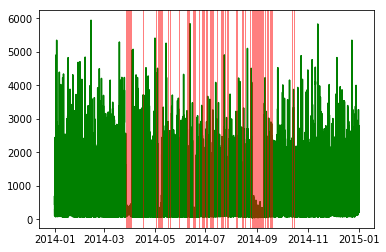

In [10]:
Y = np.hstack(inactivity_anomaly_vectors)
unexpected_anomalies_count = 0
current_anomaly = []
unexpected_anomalies = []
min_anomaly_length = 5
year = 2014
for k, y in enumerate(Y):
    if y >= 2:
        if y >= 3:
            unexpected_anomalies_count += 1
            current_anomaly.append(k)
    else:
        if unexpected_anomalies_count >= min_anomaly_length:
            anomaly_range = \
                [
                    datetime.datetime(year, 1, 1) + datetime.timedelta(hours=int(current_anomaly[0])),
                    datetime.datetime(year, 1, 1) + datetime.timedelta(hours=int(current_anomaly[-1])),
                ]

            unexpected_anomalies.append(anomaly_range)

        current_anomaly = []
        unexpected_anomalies_count = 0

first = '2014-01-01 00:00:00'
last = '2014-12-31 23:59:59'
unexpected_anomalies_str = [[x.strftime('%Y-%m-%d %H:%M:%S') for x in r] for r in unexpected_anomalies]
visualize_household(household_id, first, last, unexpected_anomalies_str)